In this notebook I investigate community detection in the RDPG setting where
$ X_{i} \stackrel{iid}{\sim} \pi X + (1 - \pi) \nu(t) $. Let $ Y_{i} = 1 $ if $ X_{i} = X $ and $ Y_{i} = 2 $ otherwise, with applications to the unweighted drosophilia larva MB.

In particular, i assume 

$ X \in \mathbb{R}^{p} $, 

$ t \sim Unif(0,1)^{d} $, 

$ \nu: [0,1]^{d} \rightarrow S \subset \mathbb{R}^{p} $

where S is a surface in $ \mathbb{R}^{d} $ parameterized by $ t $. In the RDPG setting we also need for all $ x, y \in S \cup \{X\}, \langle x, y \rangle \in [0, 1] $. If unclear (or just wrong), $ X_{i} $ is either equal to $ X $ or uniformly distributed on the surface of $ S $. 

Let $ P = \mathbf{X}\mathbf{X}^{T} $, $ A \in \{0, 1\}^{n \times n} \sim Bernoulli(P) $ where $ A $ is hollow and symmetric.

Given $ A $ the goal is to recover the community labels $ Y $.

If, say, $ X_{i} \sim \pi X^{(1)} + (1 - \pi)X^{(2)} $ then we could use GMM o ASE to estimate communities -- but we are not in that setting. Instead, we can iterate over subsets of $ [K] $, given by the estimated labels from GMM, and fit a series of $ p $ dimensional polynomials. This set of surfaces may be limiting, but it allows for simple fitting and is amenable to exploratory analysis. The set of polynomials is also straight forward in the number of parameters and can be easily integrated into a penalized likelihood framework -- making comparisons across different models straight forward. 

Let $ \hat{X} = ASE(A) $ and $ \hat{Y} = GMM(\hat{X}) \subset [K]^{n} $. 

Let $ j $ be a subset of $ [K] $ and $ f_{j}(\cdot) $ be the fitted polynomial surface using the $ \hat{X} $ corresponding to the clusters of $ j $. To avoid degenerate fits, we only consider fitting the $ p - 1 $ leading terms and a the constant of the polynomial, i.e. we consider $ a_0 t_{0}^{k} + ... + a_{p-1}^{k} t_{p-1} + a_{p} $. To calculate the likelihood of the model we make yet another assumption -- that $ \hat{X} | X_{i}, \nu \sim N(X_{i}, \nabla \nu(X_{i}) \sigma^{2}) $. Or, given the latent position and the true surface, the estimated postition is normally distributed along the vector perpendicular to $ S $ at $ X_{i} $ with variance that does not depend on $ X_{i} $.

Let $ r_{i} = \hat{X}_{i} - f_{j}(\hat{X}_{i}) $. Then, under the model assumptions, the likelihood of observing the estimated latent positions associated with $ j $ is given by
$$ \mathcal{L}_{S, j} = \left|\int_{\hat{S}} 1 ds\right|^{-n_{j}} \prod_{i=1}^{n_{j}} \left(\frac{1}{\sqrt{2\pi}}\right)^{n_{j}}  \exp{\left\{-\frac{1}{2 \hat{\sigma}^{2}} r_{i}^{2}\right\}} $$

and, combined with the likelihood of observing the remaining estimated positions (associated with Gaussians of labels not in $ j $), we have
$$ \mathcal{L}_{j} = \left( \left|\int_{\hat{S}} 1 ds\right|^{-n_{j}} \prod_{i=1}^{n_{j}} \left(\frac{\hat{\pi}_{j}}{\sqrt{2\pi\hat{\sigma}^{2}}}\right)^{n_{j}}  \exp{\left\{-\frac{1}{2 \hat{\sigma}^{2}} r_{i}^{2}\right\}} \right) \prod_{k \not \in j}\prod_{t:\hat{Y}_{t} = k} \frac{\hat{\pi}_{k}}{\sqrt{2 \pi \det(\hat{\Sigma}_{k})}} \exp{\left\{-\frac{1}{2} (\hat{X}_{t} - \hat{\mu}_{k})^{T} \hat{\Sigma}^{-1}_{k} (\hat{X}_{t} - \hat{\mu}_{k})\right\}} $$ where $ \hat{\pi}_{k}, \hat{\mu}_{k}, \hat{\Sigma}_{k} $ are the mixing proportion, mean and covariance estimates given by GMM and $ \hat{\pi}_{j} $ is the proportion of data in the estimated surface.

With the model posited and its likelihood laid out, our goal is clear -- find the subset of $ [K] $ that maximizes $ \mathcal{L}_{j} $ (or some penalized version of it).

Let $ |j| = s $, we have (recall $ \hat{X} \in \mathbb{R}^{p} $)

$ (K - s - 1)p $ parameters for the means associated with the Gaussians

$ (K - s - 1)p(p-1)/2 $ parameters for the covariances associated with the Gaussians

$ p $ parameters for the estimated surface

$ 1 $ parameter for the variance off of the surface

$ K - s - 1 $ parameters for mixing coefficients 

$ T = (K - s - 1)p + (K - s - 1)p(p-1)/2 + p + 1 + K - s - 1 $

$ BIC_{j} = 2\mathcal{L}_{j} - T \log n $

Hence, one way to choose a model is by maximizing $ BIC_{j} $ over all subsets of $ [K] $.

NB: The biggest challenge is estimating the integral of the surface...

In [5]:
import numpy as np
from wLSM_utils import *
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed as ASE
from graspy.cluster import GaussianCluster as GCLUST
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import adjusted_rand_score as ari
from sklearn.neighbors import KDTree
from scipy.spatial import Delaunay

from itertools import combinations
from scipy.stats import norm
import scipy.optimize as optimize

%matplotlib inline

In [6]:
def generate_cyclops(X, n, pi, density=None, density_params=[0,1], acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    counts = np.random.multinomial(n, [pi, 1 - pi]).astype(int)
    
    if density is None:
        density = np.random.uniform
        U = sample(counts[0], density, density_params)
        X_L = get_latent_positions(U)
    else:
#         U = sample(counts[0], density, density_params)
        density_params = np.array(density_params)
        d = len(density_params)
        if density_params.ndim == 1:
            pass
        else:
            X_temp = np.stack([sample(counts[0], density, density_params[i]) for i in range(d)], axis=1)
            quad = np.sum(np.array([3, 3])*X_temp[:,:2]**2, axis=1)[:, np.newaxis]
            print(quad, X_temp[0, 0], X_temp[0, 1], X_temp[0, 0]**2 + X_temp[0, 1]**2)
            X_L = np.concatenate((X_temp[:,:2], quad), axis=1)
        
    X = X[:, np.newaxis].T
    
    All_X = np.concatenate((X_L, X), axis = 0)
    
    P = All_X @ All_X.T
    
    A = sbm(np.concatenate((np.ones(counts[0]).astype(int), [counts[1]])), P)
    
    return A, counts

def quadratic(data, params):
    if data.ndim == 1:
        sum_ = np.sum(data[:-1]**2 * params[:-1]) + params[-1]
        return sum_
    elif data.ndim == 2:
        sums = np.sum(data[:, :-1]**2 * params[:-1], axis = 1) + params[-1]
        return sums
    else:
        raise ValueError("unsuppored data")
        
def quadratic_log_likelihood(data, params, curve_density=False):
    n, d = data.shape
    fitted_Z = quadratic(data, params)
    residuals = fitted_Z - data[:, -1] # assuming data.ndim == 2
    std = np.std(residuals, ddof=1)
    
    log_likelihood = 0
    for i in range(n):
        log_likelihood += np.log(norm.pdf(residuals[i], fitted_Z[i], std))
        
    if curve_density:
        log_A = 0
    else:
        maxes = np.array([max(data[:, i]) for i in range(data.shape[1] - 1)])
        mins = np.array([min(data[:, i]) for i in range(data.shape[1] - 1)])
        area = np.prod(maxes - mins)
        log_A = temp_n * np.log(1/area)
        
    return log_likelihood + log_A

def func(data, a, b, c):
    if data.ndim == 1:
        return a*(data[0])**2 + b*data[1]**2 + c
    return a*(data[:, 0])**2 + b*data[:, 1]**2 + c

def triangle_surface_area_approximation(data, func, params, K = 10):
    n, d = data.shape
    fitted_Z = quadratic(data, params)
    data_S = data.copy()
    data_S[:, -1] = fitted_Z
    
    kdt = KDTree(data_S)
    
    return

def monte_carlo_integration(data, func, params, M, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = data.shape
    
    maxes = np.array([max(data[:, i]) for i in range(d-1)])
    mins = np.array([min(data[:, i]) for i in range(d-1)])
    area = np.prod(maxes - mins)
    
    sample = np.zeros((M, d-1))
    
    for coord in range(d-1):
        sample[:, coord] = np.random.uniform(mins[coord], maxes[coord])
        
    sum_f = 0
    for it in range(M):
        sum_f += func(sample[it, :], params[0], params[1], params[2])
        
    estimated_integral = (area)*(1/M)*sum_f
    
    return estimated_integral

I first consider a simulation setting with $ X = [0.2, 0.2, 0.2] $ and the underlying surface is the HW curve. I estimate the HW curve (incorrectly) using Least squares under the assumption $ X_{3} = a_{0}X_{1}^{2} + a_{1}X_{2}^{2} + a_{2}X_{1}X_{2} + a_{3} $. In this setting, $ \pi = 0.1 = $ proportion of samples with latent position $ [0.2, 0.2, 0.2] $.

In [7]:
X = np.array([0.2, 0.2, 0.2])

n = 1000
pi = 0.9

A, counts = generate_cyclops(X, n, pi, None)
c = [0]*counts[0]
c += [1]*counts[1]

In [8]:
np.random.seed(2)

S = c == np.zeros(len(c))

ase = ASE(n_components=3)
X_hat = ase.fit_transform(A)

params, pcov = optimize.curve_fit(func, X_hat[c == np.zeros(len(c)).astype(int), :2], X_hat[c == np.zeros(len(c)).astype(int), 2])

In [9]:
import _pickle as pkl
pkl.dump(X_hat, open('X_hat.pkl', 'wb'))

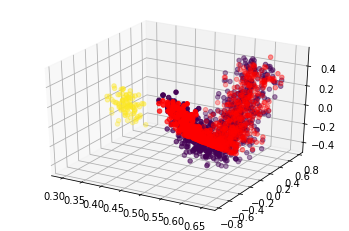

In [10]:
fitted_Z = quadratic(X_hat, params)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=c)
ax.scatter(X_hat[S, 0], X_hat[S, 1], fitted_Z[S], c='r')

In [11]:
delly = Delaunay(X_hat[: ,:2])
content = np.sum([calculate_simplex_content(X_hat[del_]) for del_ in delly.simplices])

In [12]:
content

2.695619886609056

In [13]:
kdt = KDTree(X_hat)
idx = kdt.query(X_hat, k + 1, return_distance=False)
idx[:, 1:]

triangles = []
content = 0
for i in range(n):
    combos = combinations(idx[i, 1:], 2) # should this be d - 1 ..?
    for combo in combos:
        combo_ = np.array(list(combo))
        temp_tri = np.concatenate((combo, [i]))
        if set(temp_tri) not in triangles:
            content += calculate_simplex_content(X_hat[temp_tri])
            triangles.append(set(temp_tri))

NameError: name 'k' is not defined

In [15]:
delly = Delaunay(X_hat[:, :2])
delly.simplices

array([[505, 554, 667],
       [554, 505, 321],
       [969, 857, 830],
       ...,
       [854, 817, 678],
       [854, 678, 702],
       [649, 854, 702]], dtype=int32)

In [44]:
len(triangles), 

(784,)

In [24]:
idx.shape

(1000, 6)

In [9]:
content

6.507733593227039

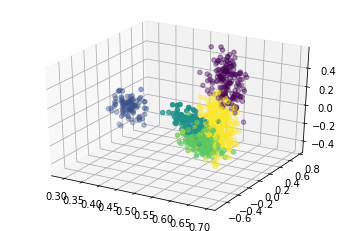

In [7]:
gclust = GCLUST(max_components=10)
c_hat = gclust.fit_predict(X_hat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=c_hat)

In [17]:
import _pickle as pkl
class_idx = pkl.load(open('class_idx_cyclops_par.pkl', 'rb'))
combos = pkl.load(open('combos_cyclops_par.pkl', 'rb'))
aris = pkl.load(open('aris_cyclops_par.pkl', 'rb'))
bic = pkl.load(open('bic_cyclops_par.pkl', 'rb'))
likelihoods = pkl.load(open('loglikelihoods_cyclops_par.pkl', 'rb'))

Text(0.5, 1.0, 'Clustering with best ARI')

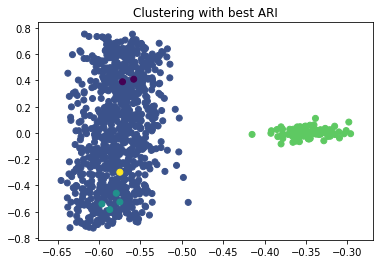

In [18]:
combo = combos[np.argmax(aris)]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat.copy()
temp_c_hat[temp_quad_labels] = temp_label

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=temp_c_hat)
ax.set_title('Clustering with best ARI')

Text(0.5, 1.0, 'Original clustering')

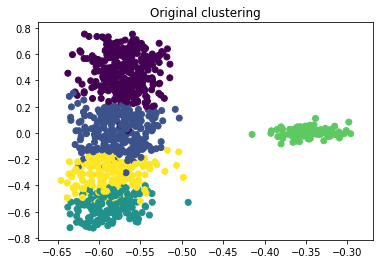

In [19]:
fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=c_hat)
ax.set_title('Original clustering')

Text(0.5, 1.0, 'Clustering with best BIC')

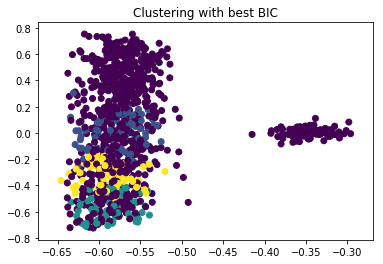

In [20]:
combo = combos[np.argmax(bic)]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat.copy()
temp_c_hat[temp_quad_labels] = temp_label

# params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2])

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=temp_c_hat)
ax.set_title('Clustering with best BIC')

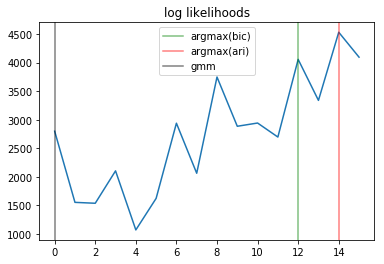

In [26]:
fig, ax = plt.subplots(1,1)
combo_lengths = np.array([len(cmbo) for cmbo in combos[1:]])
K = combo_lengths[np.argmax(combo_lengths)]
ax.plot(np.arange(2**K), likelihoods)
ax.set_title("log likelihoods")
ax.axvline(x=np.argmax(bic), c ='g', alpha=0.5, label='argmax(bic)')
ax.axvline(x=np.argmax(aris), c ='r', alpha=0.5, label='argmax(ari)')
ax.axvline(x=0, c='k', alpha=0.5, label="gmm")
ax.legend()

In [22]:
print(combos)

[None, array([0]), array([1]), array([2]), array([3]), array([0, 1]), array([0, 2]), array([0, 3]), array([1, 2]), array([1, 3]), array([2, 3]), array([0, 1, 2]), array([0, 1, 3]), array([0, 2, 3]), array([1, 2, 3]), array([0, 1, 2, 3])]


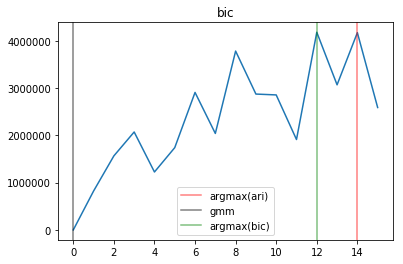

In [27]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), bic)
ax.axvline(x=np.argmax(aris), c='r', alpha=0.5, label = 'argmax(ari)')
ax.axvline(x=0, c='k', alpha=0.5, label="gmm")
ax.axvline(x=np.argmax(bic), c ='g', alpha=0.5, label='argmax(bic)')
ax.set_title('bic')
ax.legend()

The clustering with the highest BIC has an ARI of -0.05003888928068158, whereas GMM results in an ARI of 0.17533020085791695


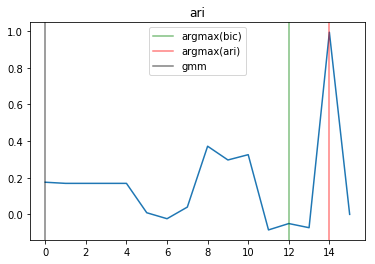

In [28]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), aris)
ax.axvline(x=np.argmax(bic), c = 'g', alpha=0.5, label="argmax(bic)")
ax.axvline(x=np.argmax(aris), c='r', alpha=0.5, label = 'argmax(ari)')
ax.axvline(x=0, c='k', alpha=0.5, label="gmm")
ax.set_title('ari')
ax.legend()
plt.savefig('ari_dros_par.png')

bic_ari = aris[np.argmax(bic)]
print("The clustering with the highest BIC has an ARI of {}, whereas GMM results in an ARI of {}".format(bic_ari, aris[0]))

In [ ]:
# Now, on the uweighted right hemisphere of the drosophila larva MB

In [41]:
from graspy.datasets import load_drosophila_left, load_drosophila_right
from graspy.utils import binarize

right_adj, right_labels = load_drosophila_right(return_labels=True)

np.random.seed(16661)
A_right = binarize(right_adj)
X_hat = np.concatenate(ASE(n_components=3).fit_transform(A_right), axis=1)
n, d = X_hat.shape

gclust_right = GCLUST(max_components=15)
c_hat = gclust_right.fit_predict(X_hat)
unique_labels = np.unique(c_hat)
K = len(unique_labels)

In [42]:
import _pickle as pkl

class_idx = pkl.load(open('class_idx_dros_par.pkl', 'rb'))
combos = pkl.load(open('combos_dros_par.pkl', 'rb'))
aris = pkl.load(open('aris_dros_par.pkl', 'rb'))
bic = pkl.load(open('bic_dros_par.pkl', 'rb'))
loglikelihoods = pkl.load(open('loglikelihoods_dros_par.pkl', 'rb'))

Text(0.5, 1.0, 'Clustering with best ARI')

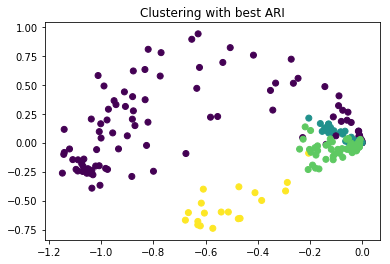

In [43]:
combo = combos[np.argmax(aris)]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat.copy()
temp_c_hat[temp_quad_labels] = temp_label

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=temp_c_hat)
ax.set_title('Clustering with best ARI')

Text(0.5, 1.0, 'Original clustering')

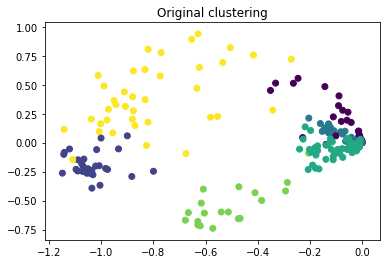

In [44]:
fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=c_hat)
ax.set_title('Original clustering')

Text(0.5, 1.0, 'Clustering with best BIC')

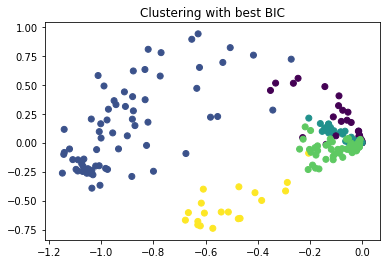

In [45]:
combo = combos[np.argmax(bic)]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat.copy()
temp_c_hat[temp_quad_labels] = temp_label

# params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2])

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=temp_c_hat)
ax.set_title('Clustering with best BIC')

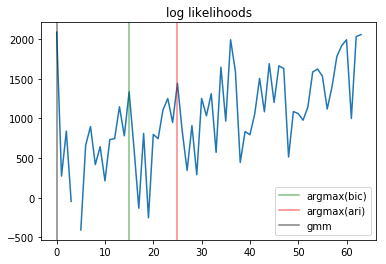

In [46]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), loglikelihoods)
ax.set_title("log likelihoods")
ax.axvline(x=np.argmax(bic), c ='g', alpha=0.5, label='argmax(bic)')
ax.axvline(x=np.argmax(aris), c ='r', alpha=0.5, label='argmax(ari)')
ax.axvline(x=0, c='k', alpha=0.5, label="gmm")
ax.legend()
# plt.savefig('log_likelihoods_dros_par.png')

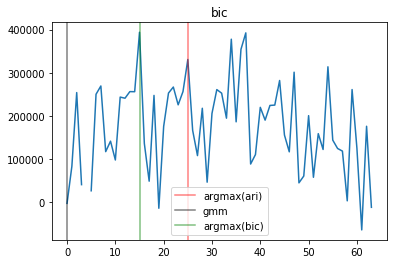

In [47]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), bic)
ax.axvline(x=np.argmax(aris), c='r', alpha=0.5, label = 'argmax(ari)')
ax.axvline(x=0, c='k', alpha=0.5, label="gmm")
ax.axvline(x=np.argmax(bic), c ='g', alpha=0.5, label='argmax(bic)')
ax.set_title('bic')
ax.legend()
# plt.savefig('bic_dros_par.png')

The clustering with the highest BIC has an ARI of 0.7259926581168602, whereas GMM results in an ARI of 0.5825531951099335


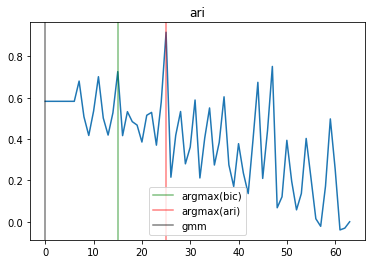

In [48]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), aris)
ax.axvline(x=np.argmax(bic), c = 'g', alpha=0.5, label="argmax(bic)")
ax.axvline(x=np.argmax(aris), c='r', alpha=0.5, label = 'argmax(ari)')
ax.axvline(x=0, c='k', alpha=0.5, label="gmm")
ax.set_title('ari')
ax.legend()
plt.savefig('ari_dros_par.png')

bic_ari = aris[np.argmax(bic)]
print("The clustering with the highest BIC has an ARI of {}, whereas GMM results in an ARI of {}".format(bic_ari, aris[0]))

In [ ]:
#- Code graveyeard

unique_labels = np.unique(c_hat)
K = len(unique_labels)
M = 10**8

class_idx = np.array([np.where(c_hat == u)[0] for u in unique_labels])

loglikelihoods = [np.sum(gclust.model_.score_samples(X_hat))]
combos = [None]
aris = [ari(c, c_hat)]
bic = [gclust.model_.bic(X_hat)]

n, d = X_hat.shape

# Plot for each fitted quad
for k in range(len(unique_labels)):
    for combo in list(combinations(np.unique(c_hat), k+1)):
        combo = np.array(list(combo)).astype(int)
        combos.append(combo)
        
        print(combo)
        
        temp_quad_labels = np.concatenate(class_idx[combo])
        temp_n = len(temp_quad_labels)
        temp_K = K - len(combo)
        temp_mean_params = temp_K * d
        temp_cov_params = temp_K * d * (d + 1) / 2
        temp_quad_params = (d - 1)*2 + d - 1 + (d - 1) * (d - 2) / 2 + 1
        temp_n_params = temp_mean_params + temp_cov_params
        temp_n_params = temp_quad_params + temp_K - 1
        
        temp_label = min(combo)
        temp_c_hat = c_hat.copy()
        temp_c_hat[temp_quad_labels] = temp_label
        
        params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2])
        
        integral = monte_carlo_integration(X_hat[temp_quad_labels], func, params, M)
        temp_density = 1/integral
        
        quad_log_likelihood = quadratic_log_likelihood(X_hat[temp_quad_labels], params, curve_density=False)
        quad_log_likelihood += temp_n * np.log(temp_density)
        gmm_log_likelihood = np.sum(gclust.model_.score_samples(X_hat[-temp_quad_labels]))
        
        loglikelihoods.append(quad_log_likelihood + gmm_log_likelihood)
        aris.append(ari(c, temp_c_hat))
        bic.append(2*gmm_log_likelihood*(n - temp_n) + 2*quad_log_likelihood*temp_n -
                        temp_n_params * np.log(n))

In [ ]:
def quadratic(data, params):
    if data.ndim == 1:
        sum_ = np.sum(data[:-1]**2 * params[:-1]) + params[-1]
        return sum_
    elif data.ndim == 2:
        sums = np.sum(data[:, :-1]**2 * params[:-1], axis = 1) + params[-1]
        return sums
    else:
        raise ValueError("unsuppored data")
        
def quadratic_log_likelihood(data, params, curve_density=False):
    n, d = data.shape
    fitted_Z = quadratic(data, params)
    residuals = fitted_Z - data[:, -1] # assuming data.ndim == 2
    std = np.std(residuals, ddof=1)
    
    log_likelihood = 0
    for i in range(n):
        log_likelihood += np.log(norm.pdf(residuals[i], fitted_Z[i], std))
        
    if curve_density:
        log_A = 0
    else:
        maxes = np.array([max(data[:, i]) for i in range(data.shape[1] - 1)])
        mins = np.array([min(data[:, i]) for i in range(data.shape[1] - 1)])
        area = np.prod(maxes - mins)
        log_A = temp_n * np.log(1/area)
        
    return log_likelihood + log_A

def func(data, a, b, c):
    if data.ndim == 1:
        return a*(data[0])**2 + b*data[1]**2 + c
    return a*(data[:, 0])**2 + b*data[:, 1]**2 + c

def monte_carlo_integration(data, func, params, M, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = data.shape
    
    maxes = np.array([max(data[:, i]) for i in range(d-1)])
    mins = np.array([min(data[:, i]) for i in range(d-1)])
    area = np.prod(maxes - mins)
    
    sample = np.zeros((M, d-1))
    
    for coord in range(d-1):
        sample[:, coord] = np.random.uniform(mins[coord], maxes[coord])
        
    sum_f = 0
    for it in range(M):
        sum_f += func(sample[it, :], params[0], params[1], params[2])
        
    estimated_integral = (area)*(1/M)*sum_f
    
    return estimated_integral